In [1]:
import pandas as pd
import numpy as np
from numpy.random import normal
import seaborn as sb
import scipy as sc
import scipy.stats as st
from scipy.optimize import curve_fit
from tqdm import tqdm
import time
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random
import warnings

pd.set_option("display.precision", 8)

https://www.kaggle.com/atulanandjha/national-stock-exchange-time-series?select=tcs_stock.csv

In [2]:
source_data_path = "./../tcs_stock.csv"

# Context

The National Stock Exchange of India Ltd. (NSE) is an Indian stock exchange located at Mumbai, Maharashtra, India. National Stock Exchange (NSE) was established in 1992 as a demutualized electronic exchange. It was promoted by leading financial institutions on request of the Government of India. It is India’s largest exchange by turnover. In 1994, it launched electronic screen-based trading. Thereafter, it went on to launch index futures and internet trading in 2000, which were the first of its kind in the country.

This dataset represents stock exchange of high rated Indian company Tata Consultancy Services (TCS) from 01-01-2015 to 31-12-2015.

# Data description
* Date - date on which data is recorded
* Symbol - NSE symbol of the stock
* Series - series of that stock | EQ - Equity
* Prev Close - last day close point
* Open - current day open point
* High - current day highest point
* Low - current day lowest point
* Last - the final quoted trading price for a particular stock, or stock-market index, during the most recent day of trading
* Close - closing point for the current day
* VWAP - volume-weighted average price is the ratio of the value traded to total volume traded over a particular time horizon
* Volume - the amount of a security that was traded during a given period of time.
* Turnover - total Turnover of the stock till that day
* Trades - number of buy or Sell of the stock.
* Deliverable - volumethe quantity of shares which actually move from one set of people to another set of people.
* %Deliverble - percentage deliverables of that stock

Dataset consists of 248 records with 15 features.

You can see features desription and example of data below.

In [3]:
raw_df = pd.read_csv(source_data_path)

In [4]:
raw_df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,248.00000000,248.00000000,248.00000000,248.00000000,248.00000000,248.00000000,248.00000000,2.48000000e+02,2.48000000e+02,248.00000000,2.48000000e+02,248.00000000
mean,2538.20745968,2542.17278226,2563.58044355,2514.40846774,2538.03971774,2537.71794355,2538.43213710,1.17229615e+06,2.97748865e+14,66873.60887097,7.96057548e+05,0.67033629
std,86.82935866,87.60569877,90.59836765,82.95277758,86.84930504,87.05781439,86.81305296,6.22063547e+05,1.57644310e+14,28882.90678727,4.30991092e+05,0.09096782
min,2319.80000000,2319.40000000,2343.90000000,2315.25000000,2321.00000000,2319.80000000,2322.27000000,6.75820000e+04,1.66754978e+13,5197.00000000,3.40030000e+04,0.28830000
25%,2495.31250000,2499.50000000,2518.90000000,2472.10000000,2497.50000000,2495.15000000,2496.66500000,7.82135250e+05,1.95071574e+14,45476.25000000,4.87106500e+05,0.61085000
50%,2543.05000000,2548.50000000,2566.00000000,2520.00000000,2540.15000000,2541.47500000,2540.44500000,1.03102400e+06,2.63178319e+14,61449.50000000,7.00953000e+05,0.68560000
75%,2592.00000000,2594.25000000,2615.75000000,2567.30000000,2593.42500000,2592.00000000,2592.60750000,1.39326625e+06,3.55038967e+14,82066.75000000,9.94662750e+05,0.72605000
max,2776.00000000,2788.00000000,2812.10000000,2721.90000000,2785.10000000,2776.00000000,2763.04000000,4.83437100e+06,1.20643498e+15,211247.00000000,2.98913200e+06,0.89010000


In [5]:
raw_df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,TCS,EQ,2558.25,2567.0,2567.00,2541.00,2550.00,2545.55,2548.51,183415,4.67434456e+13,8002,52870,0.2883
1,2015-01-02,TCS,EQ,2545.55,2551.0,2590.95,2550.60,2588.40,2579.45,2568.19,462870,1.18874011e+14,27585,309350,0.6683
2,2015-01-05,TCS,EQ,2579.45,2581.0,2599.90,2524.65,2538.10,2540.25,2563.94,877121,2.24888554e+14,43234,456728,0.5207
3,2015-01-06,TCS,EQ,2540.25,2529.1,2529.10,2440.00,2450.05,2446.60,2466.90,1211892,2.98961536e+14,84503,714306,0.5894
4,2015-01-07,TCS,EQ,2446.60,2470.0,2479.15,2407.45,2426.90,2417.70,2433.96,1318166,3.20836246e+14,101741,886368,0.6724


## Step 1. Choose subsample with main variables for your further analysis. 

For this lab you need subsample with 3-5 random variables, at least half of them should be described with continuous random variable type

In [6]:
features = ['Open', 'High', 'Low', 'Close']
df = raw_df[features]
df.head()

,Open,High,Low,Close
0,2567.0,2567.00,2541.00,2545.55
1,2551.0,2590.95,2550.60,2579.45
2,2581.0,2599.90,2524.65,2540.25
3,2529.1,2529.10,2440.00,2446.60
4,2470.0,2479.15,2407.45,2417.70


## Step 2. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).


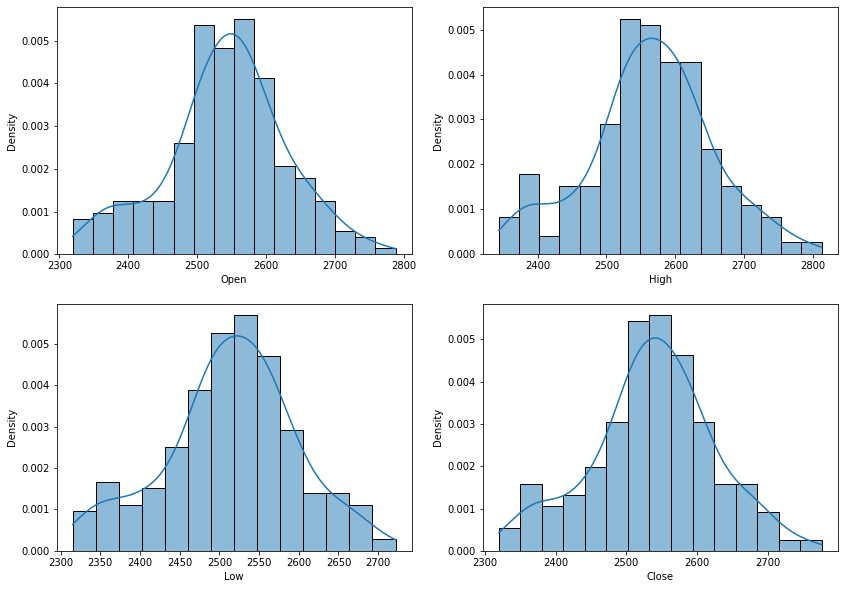

In [7]:
# initialize figure canvas
fig, ax = plt.subplots(2, 2, figsize=(14,10))
sb.histplot(df['Open'], ax=ax[0,0], kde=True, stat="density")
sb.histplot(df['High'], ax=ax[0,1], kde=True, stat="density")
sb.histplot(df['Low'], ax=ax[1,0], kde=True, stat="density")
sb.histplot(df['Close'], ax=ax[1,1], kde=True, stat="density")

plt.show()

## Step 3. You need to make an estimation of order statistics and represent them as “box with whiskers” plot.
we will find quintiles estimations


In [8]:
def quantilies(array):
    return [
        np.quantile(array, 0.1),
        np.quantile(array, 0.25), 
        np.quantile(array, 0.5), 
        np.quantile(array, 0.75),
        np.quantile(array, 0.9)
    ]

results = {}
for feature in features:
    results[feature] = quantilies(df[feature].to_numpy())

pd.DataFrame.from_dict(results, orient='index',columns=['0.1', '0.25', '0.5', '0.75', '0.9'])

,0.1,0.25,0.5,0.75,0.9
Open,2418.690,2499.50,2548.500,2594.25,2651.160
High,2438.155,2518.90,2566.000,2615.75,2678.785
Low,2400.455,2472.10,2520.000,2567.30,2611.890
Close,2417.430,2495.15,2541.475,2592.00,2648.885


In [9]:
def draw(label, method, df, width = 7):
    data = df[label]
    quantiles = quantilies(data.to_numpy())
    fig, ax = plt.subplots(2,1, figsize=(width, 5), sharex=True, gridspec_kw={'height_ratios': [2,0.5]})
    fig.suptitle(label)
    
    sb.histplot(data, ax=ax[0], kde = False, stat=method)
    for q in quantiles:
        ax[0].axvline(q, color='r', linestyle='--', alpha=0.7)

    sb.boxplot(x=data, ax=ax[1])
    for q in quantiles:
        ax[1].axvline(q, color='r', linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()

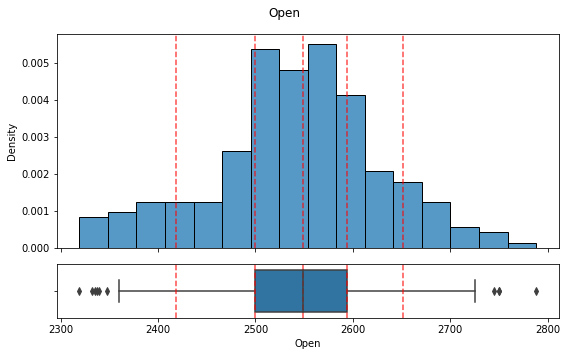

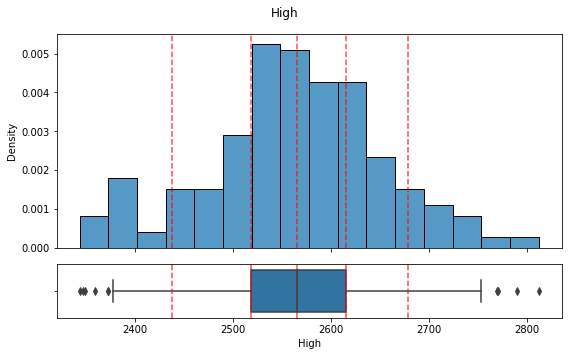

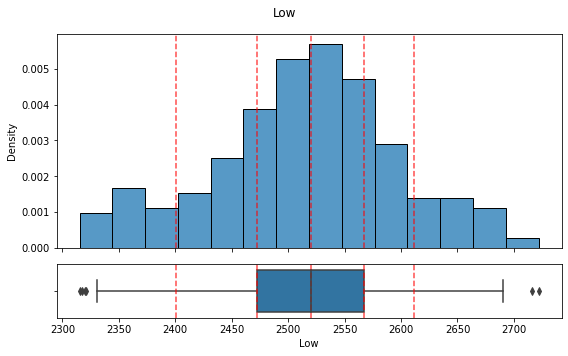

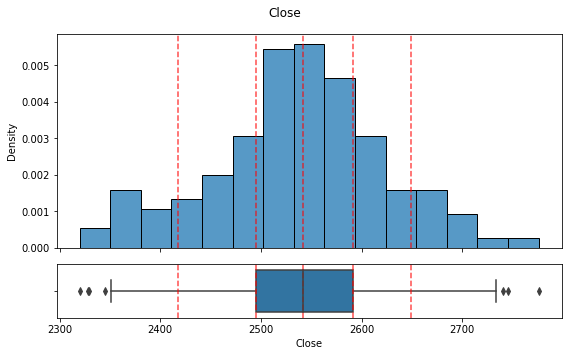

In [10]:
for feature in features:
    draw(feature, 'density', df, 8)

## Step 4. Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results.

In this part, we will look for a suitable distribution for each of the selected features using scipy library.

Algorithm:
We have collected all scipy distribution objects in variable ALL_DISTRIBUTIONS.

For each feature, we build a histogram and take the center values for the columns using Danoe'S formula. After we calculate SSE (sum of squared estimate of errors) using formula $SSE = \sum^n_i (y_{𝑐𝑒𝑛𝑡𝑟𝑎𝑙\_𝑖} - y_{pdf\_i})^2$. The distribution with the lowest SSE value is taken as the most suitable.

$ y_{pdf\_i}$ are calculated usig PDF for each distribution. Correct PDF we get using scipy.fit_data.

In [19]:
def danoes_formula(data):
    """
    DANOE'S FORMULA
    
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disabled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters
    ALL_DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm, st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    MY_DISTRIBUTIONS = [st.invgauss]

    # Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in tqdm(ALL_DISTRIBUTIONS):
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution.name] = [float(sse), arg, round(loc, 3), round(scale, 3)]
    
    res = pd.DataFrame.from_dict(results, orient='index',columns=['SSE', 'ARG', 'LOC', 'SCALE'])
    return res

In [20]:
def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = results.sort_values(by=['SSE'])[:5]
    
    display(N_DISTRIBUTIONS)

    ## Histogram of data
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='black')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')
    
    for distribution, values in N_DISTRIBUTIONS.iterrows():
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = getattr(st.distributions, distribution).pdf(x_plot, loc=values['LOC'], scale=values['SCALE'], *values['ARG'])
        plt.plot(x_plot, y_plot, label=distribution)
    
    plt.legend(title='Distributions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

100%|████████████████████████████████████████████████████████████████████████| 86/86 [00:08<00:00,  9.73it/s]


,SSE,ARG,LOC,SCALE
laplace,0.00000085,(),2548.500,66.478
loglaplace,0.00000086,"(38.169396159952825,)",-1.390,2550.390
hypsecant,0.00000122,(),2545.465,57.223
gennorm,0.00000126,"(1.4014591878045362,)",2545.773,96.095
genlogistic,0.00000143,"(0.7390392202666065,)",2565.231,43.053


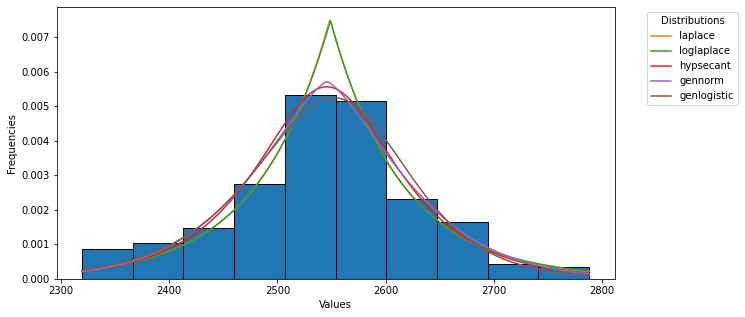

100%|████████████████████████████████████████████████████████████████████████| 86/86 [00:09<00:00,  9.24it/s]


,SSE,ARG,LOC,SCALE
hypsecant,0.00000109,(),2566.114,59.518
dweibull,0.00000112,"(1.1490674893116348,)",2561.555,72.897
genlogistic,0.00000117,"(0.7962286855589259,)",2581.887,46.169
gennorm,0.00000121,"(1.486995842398066,)",2565.162,104.718
logistic,0.00000121,(),2565.381,50.480


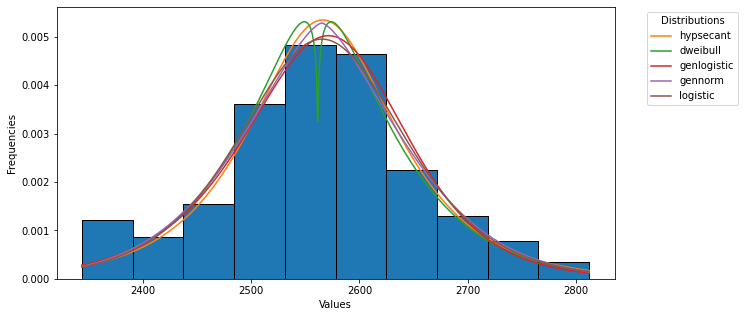

100%|████████████████████████████████████████████████████████████████████████| 86/86 [00:09<00:00,  9.23it/s]


,SSE,ARG,LOC,SCALE
laplace,0.00000133,(),2520.000,64.048
loglaplace,0.00000142,"(39.18516955081586,)",-1.370,2521.370
foldcauchy,0.00000224,"(55.16844084327158,)",-0.529,45.703
cauchy,0.00000224,(),2520.831,45.691
hypsecant,0.00000244,(),2518.103,54.922


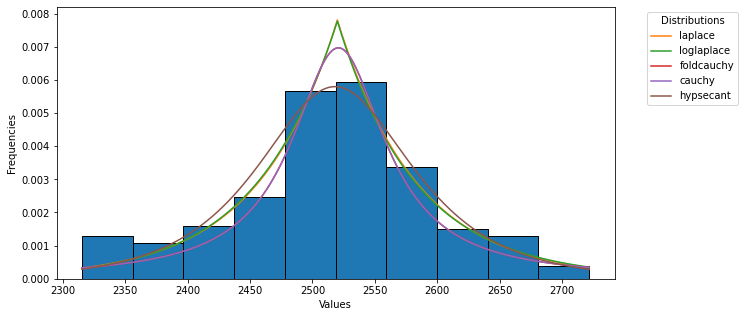

100%|████████████████████████████████████████████████████████████████████████| 86/86 [00:09<00:00,  9.34it/s]


,SSE,ARG,LOC,SCALE
laplace,0.00000077,(),2541.475,66.768
loglaplace,0.00000085,"(37.95089813785944,)",-1.380,2542.570
dweibull,0.00000094,"(1.1350707272595078,)",2541.716,69.791
hypsecant,0.00000108,(),2540.403,57.462
vonmises_line,0.00000142,"(1.1541932774700352,)",2547.157,72.843


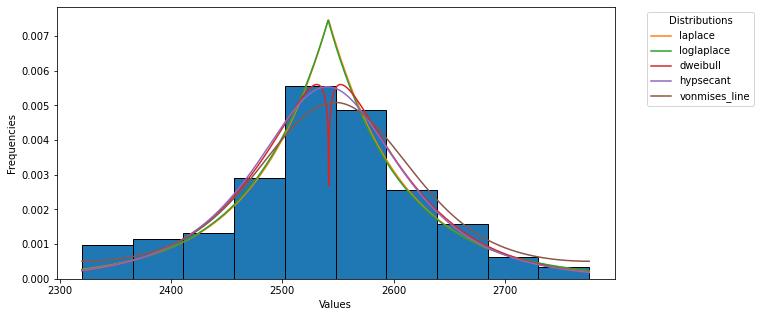

In [21]:
for feature_name in df.keys():
    data = df[feature_name]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        res = fit_data(data)
        plot_histogram(data, res, 5)
        first_value = next(iter(res.keys()))
        time.sleep(1)

Let's summarize the calculations above in mathematical terms.
For each feature (Open, High, Low, Close) we calculated histogram and PDFs of distibutions. Graphics contains legend with SSE value. As mentioned earlier, the minimum SSE value shows a suitable distribution

Looking at the legends and tables, we can conclude that all the features following distributions:
* Open - Laplace distribution
* High - Hyperbolic secant distribution
* Low - Laplace distribution
* Close - Laplace distribution

Laplace distribution PDF:
$f(x) = \frac{1}{2b} exp(-\frac{|x - \mu|}{b})$

Hyperbolic secant distribution PDF: 
$f(x)=\frac{1}{2}sech(\frac{\pi}{2}x)$  

PDF of this distribution has no parameters, but can be shifted and/or scaled using the loc and scale parameters. Specifically if we talk about scipy realization, hypsecant.pdf(x, loc, scale) is identically equivalent to hypsecant.pdf(y) / scale with $y = \frac{(x - loc)}{scale}$.

## Step 5. Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

as we can see above, our Hyperbolic secant distribution has two parameters: loc and scale

In [14]:
def estimate_params(data, var, distribution):
    res = list(getattr(st, distribution).fit(data[var]))
    return [round(i,3) for i in res]

def estimate_params_ls(data, var, distribution, bins=90):
    min_val, max_val = data[var].min(), data[var].max()
    dists, _edges = np.histogram(data[var], bins=bins, density=True)
    xs = np.linspace(min_val, max_val, num=bins)
    def f(xdata, loc, scale):
        return getattr(st.distributions, distribution).pdf(xdata, loc=loc, scale=scale)
    
    p, _ = curve_fit(f, xs, dists, p0=estimate_params(data, var, distribution), maxfev=2000)
    return [round(i,3) for i in p]

In [15]:
features_with_dist = {'Open': 'laplace', 'High': 'hypsecant', 'Low': 'laplace', 'Close': 'laplace'}
report = pd.DataFrame()

for var, distribution in features_with_dist.items():
    res = [[var, 'Maximum likelihood', estimate_params(df, var, distribution)],
            [var,'Least squares', estimate_params_ls(df, var, distribution)]]
    report = report.append(res, ignore_index=True)
    
report.columns = ["Feature", "Method", "Distribution args"]
report = report.set_index(['Feature', 'Method']).sort_index()
report

Distribution args
Feature Method                                
Close   Least squares       [2544.977, 75.884]
        Maximum likelihood  [2541.475, 66.768]
High    Least squares       [2569.022, 59.844]
        Maximum likelihood  [2566.114, 59.518]
Low     Least squares       [2522.225, 75.037]
        Maximum likelihood    [2520.0, 64.048]
Open    Least squares       [2552.261, 73.267]
        Maximum likelihood    [2548.5, 66.478]

Let's take a closer look at the table an find out what parameters have distributions:

For Close, Low, Open   
1st number in column **Distribution args** is $\mu$  
2st number in column **Distribution args** is b  

For High  
1st number in column **Distribution args** is loc  
2st number in column **Distribution args** is scale  


## Step 6. Validate your estimated parameters using QQ biplots.

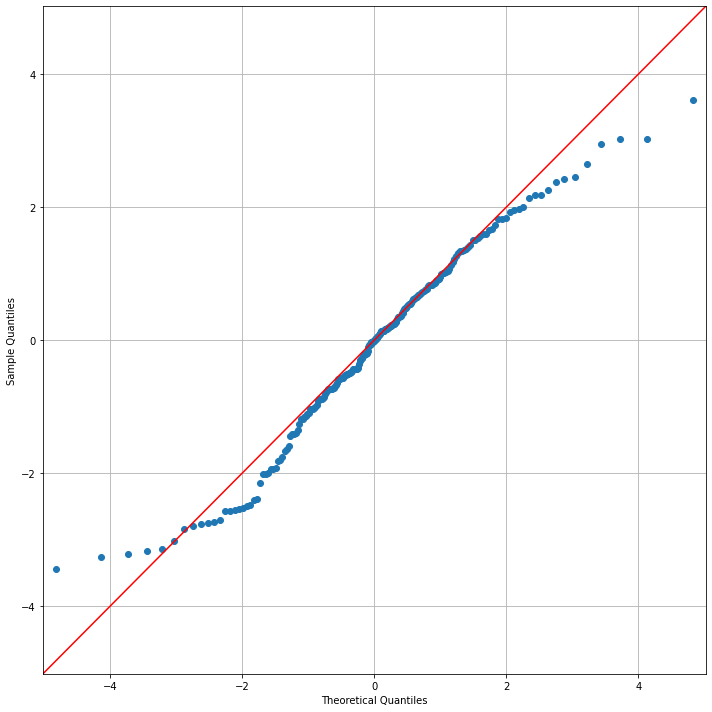

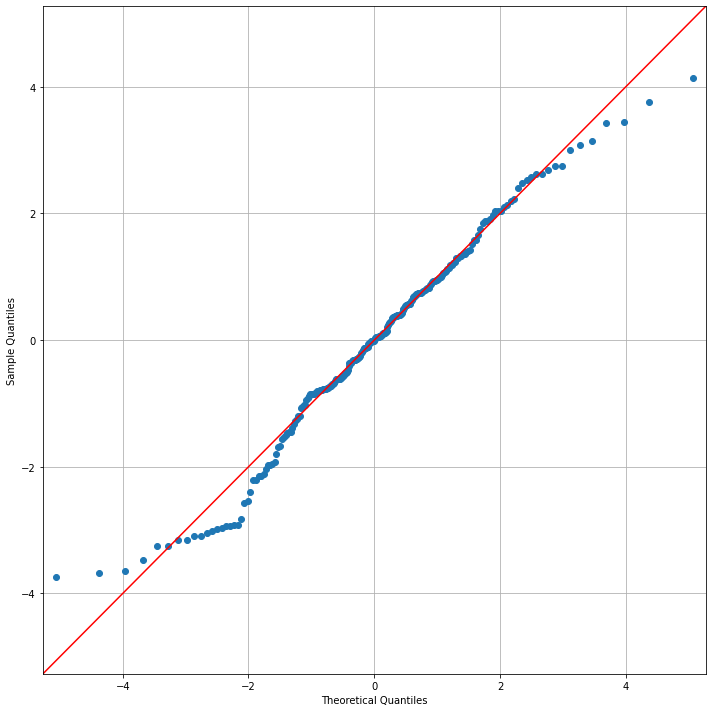

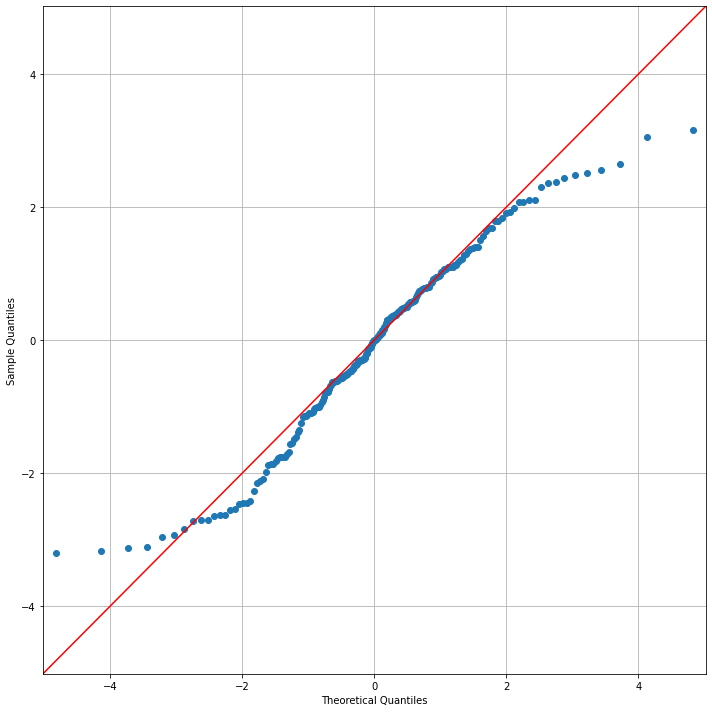

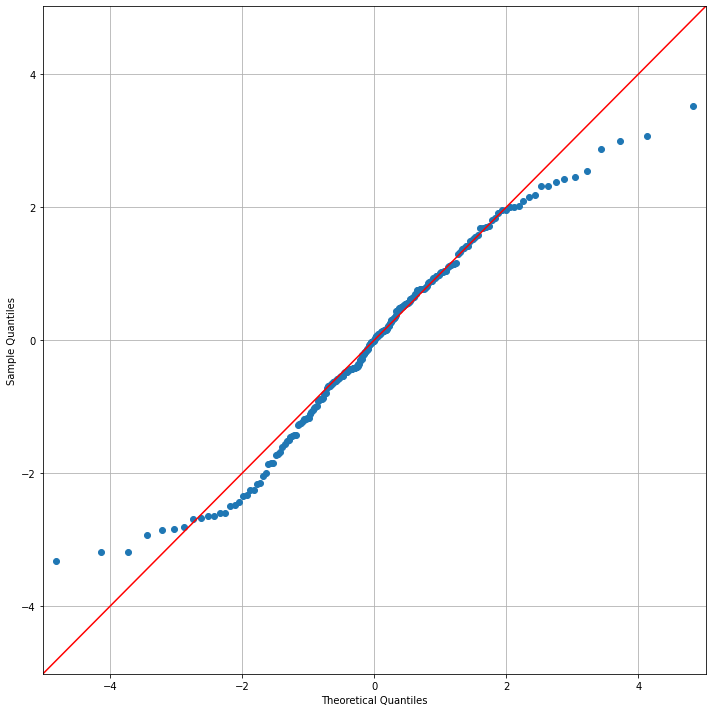

In [16]:
i = 0
for col, distribution in features_with_dist.items():
    fig, ax = plt.subplots(figsize=(10, 10), sharey=True)
    qqplot(df[col], getattr(st.distributions, distribution), fit=True, ax=ax, line="45")
    ax.grid()
    i += 1

    plt.tight_layout()
    plt.show()

The points from all plots seem to fall about a straight line. So we can conclude that the theoretical distribution is close to the real distribution of the data.

## Step 7. Estimate correctness of fitted distributions using at least 2 statistical tests.

At step 4, we fitted the distributions for each of the features using the SSE value. Now we will proof it using  statistical tests.

In [17]:
features_with_dist

{'Open': 'laplace', 'High': 'hypsecant', 'Low': 'laplace', 'Close': 'laplace'}

In the next section we are perfoming Kolmogorov-Smirnov and Cramér-von Mises statistical tests.

In [18]:
results={}
for col, dst in features_with_dist.items():
    data = df[col]
    a, b = getattr(st.distributions, distribution).fit(data)
    l1 = getattr(st.distributions, distribution)(a, b)
    
    ks_p_value = st.kstest(data, l1.cdf).pvalue
    cm_p_value = sc.stats.cramervonmises(data, l1.cdf).pvalue
    
    results[col]=[round(ks_p_value, 3), round(cm_p_value, 3)]
    
pd.DataFrame.from_dict(results, orient='index',columns=['Kolmogorov-Smirnov test', 'Cramér-von Mises test'])

,Kolmogorov-Smirnov test,Cramér-von Mises test
Open,0.295,0.598
High,0.734,0.646
Low,0.496,0.512
Close,0.478,0.705


In all cases, the p-value takes on rather high values. This means that at step 4 we have chosen the distributions well.  
For Open, Low, Close it is Laplace.  
For High it Hyperbolic secant distribution.